In [188]:
%pylab inline
import astropy.units as u
import tmm
from Getindex import load_refraction_data
index_of_refraction = load_refraction_data(Epoxy_ind=1.6,Temp = 183.)
import TMMSIM
from numba import jit
from tqdm import tqdm
from astropy.io import fits
import astropy.units as u
import os
import pickle

Populating the interactive namespace from numpy and matplotlib


/Users/zhiyuanguo/Documents/Research/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [202]:
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [3]:
@jit(nopython = True,nogil=True)
def E2V_model(n_list,epoxy_um, wlen):
    
    thickness_um = np.array([np.inf, 0.1221,0.0441,100, 0.1, 0.3,1.,epoxy_um,160, np.inf])

    # Assume normal incidence.
    theta = 0.
    R = T = 0
    for pol in 's':

        # Using tmm package to do multilayer thin-film simulation
        Res = TMMSIM.coh_tmm(pol, n_list, thickness_um, theta, 1e-3 * wlen)
        # Store R and T results
        rr,tt = Res[2],Res[3]
        R += rr
        T += tt

    A = 1 - R - T

    return(A)

# Define the gaussian function
@jit(nopython = True,nogil=True)
def gaussian(x, mu, FWHM):

    # Calculate sigma based on FWHM value 2nm
    # FWHM = 2*sqrt(2*ln2)*sigma
    sig = FWHM/(2*np.sqrt(2*np.log(2)))

    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-((x - mu)/sig)**2/2)


@jit(nopython = True,nogil=True)
def map_sim(n_list,thickmap,wlen):
    Fringe_map = np.zeros_like(thickmap)
    for i in range(len(thickmap)):
        Fringe_map[i] = E2V_model(n_list = n_list,epoxy_um = thickmap[i],wlen=wlen)
    return(Fringe_map)

In [6]:
pol = 's'
wlen = 985.1
material = ('Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Epoxy','Si_Temp','Si3N4')
n_list = np.array([index_of_refraction[m](wlen) for m in material])
thickness_um = np.array([np.inf, 0.1221,0.0441,100, 0.1, 0.3,1.,17.2,165, np.inf])
Res = TMMSIM.coh_tmm(pol, n_list, thickness_um, 0, 1e-3 * wlen)
Abor_prob = TMMSIM.absorp_in_each_layer(Res)[3]
print(Abor_prob)

0.25062459402739445


In [7]:
dbfile = open('data/Interpolator.pkl', 'rb')  
interpolator = pickle.load(dbfile)
dbfile.close()

In [8]:
hh = fits.open('data/E2V-321.fits')
MAP = hh[1].data['sim']
MAP = np.array(MAP,dtype = float)
Fitting = MAP.reshape(3974,4000)

In [78]:
wavelengths = np.array([930.9, 931. , 931.5, 931.6, 932.5, 932.6, 934. , 937.7, 937.9,
       938.9, 940.5, 942.2, 944.2, 946.1, 947.9, 950.5, 952.2, 955.5,
       957. ])

In [ ]:
937,944.2,946.1,950.5

In [79]:
line_weight = np.array([0.01592912, 0.03495227, 0.01501219, 0.05547556, 0.02008631,
       0.05518083, 0.01755911, 0.0158154 , 0.1499623 , 0.06645337,
       0.02621191, 0.03712045, 0.10545333, 0.04388156, 0.12627837,
       0.03929342, 0.09382043, 0.02529139, 0.05622267])

In [26]:
from scipy import interpolate

In [9]:
wavelengths = np.array([ 930.9,  931. ,  931.5,  931.6,  932.5,  932.6,  934. ,  937.7,
        937.9,  938.9,  940.5,  942.2,  944.2,  946.1,  947.9,  950.5,
        952.2,  955.5,  957. ,  961. ,  962.4,  967.1,  967.2,  968.3,
        968.5,  969.3,  970.2,  971.4,  972.2,  974.1,  979.2,  979.4,
        980.2,  981.5,  985.1,  987.5,  989.7,  991.7,  994.4,  994.5,
        994.8,  994.8,  994.9,  995. ,  995.9,  995.9,  996.5,  997.5,
       1000.3, 1001.4, 1001.6, 1001.7, 1002.8, 1004.6, 1006.3, 1006.4,
       1007.4, 1008.5, 1010.6, 1012.7, 1015.6, 1016.1, 1016.7, 1017.4,
       1017.5, 1018.4, 1019.2, 1020.6, 1021.2, 1021.4, 1022.9, 1023.3,
       1028.8, 1028.9, 1028.9, 1029. , 1029.9, 1031.2, 1035. , 1037.6,
       1039.9, 1042.1, 1045.3, 1047.2, 1051.2, 1052.8, 1073.2, 1075.4,
       1083.4])

line_weight = np.array([0.00316298, 0.00694032, 0.0029809 , 0.01101554, 0.00398845,
       0.01095701, 0.00348664, 0.00314039, 0.02977735, 0.01319535,
       0.00520478, 0.00737084, 0.0209394 , 0.00871337, 0.02507454,
       0.00780232, 0.01862951, 0.005022  , 0.01116389, 0.00260921,
       0.00508497, 0.00265235, 0.00269139, 0.00202333, 0.0081147 ,
       0.00384008, 0.01686226, 0.00692449, 0.02104299, 0.00727881,
       0.00563772, 0.05141642, 0.01776843, 0.00573375, 0.01105705,
       0.03611868, 0.01291705, 0.03517398, 0.00878999, 0.00425413,
       0.00893247, 0.0020274 , 0.01375227, 0.003808  , 0.01405659,
       0.00530246, 0.02092329, 0.00477209, 0.00423654, 0.00313985,
       0.02951865, 0.00879142, 0.01171418, 0.0044352 , 0.00576828,
       0.00575691, 0.00273109, 0.01846435, 0.00722891, 0.02008932,
       0.00581611, 0.00468206, 0.00234049, 0.01420987, 0.0124064 ,
       0.00560492, 0.02361332, 0.00938429, 0.00342077, 0.02776581,
       0.00747464, 0.00954719, 0.00630361, 0.00295364, 0.05785066,
       0.00294231, 0.01982836, 0.00617521, 0.0100798 , 0.03035667,
       0.01034483, 0.02652278, 0.0062507 , 0.01386685, 0.00252015,
       0.00498065, 0.00293009, 0.00310673, 0.00471446])

In [31]:
MAP = np.arange(14.02,22.01,0.01)
x = MAP
normal_interpolators = {}


for i in tqdm(range(len(wavelengths))):
    z = []
    wlen = wavelengths[i]
    material = ('Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Epoxy','Si_Temp','Si3N4')
    n_list = np.array([index_of_refraction[m](wlen) for m in material])
    pol = 's'
    a = []
    theta = 0
    for i in (range(len(MAP))):

        thickness_um = np.array([np.inf, 0.1221,0.0441,100, 0.1, 0.3,1.,MAP[i],165, np.inf])
        Res = TMMSIM.coh_tmm(pol, n_list, thickness_um, theta, 1e-3 * wlen)
        Abor_prob = TMMSIM.absorp_in_each_layer(Res)[3]
        a.append(Abor_prob)

    normal_interpolators[str(wlen)] = interpolate.interp1d(x, a, kind='cubic')

100%|██████████| 89/89 [00:09<00:00,  9.15it/s]


In [27]:
interpolators = {}


# y incident angle
th_min=0.1*u.deg 
th_max=7.13*u.deg
th_rad = np.linspace(th_min.to(u.rad).value, th_max.to(u.rad).value, 100)
# x wavelength
MAP = np.arange(14.02,22.01,0.01)
x = MAP
y = th_rad
for i in tqdm(range(len(wavelengths))):
    z = []
    wlen = wavelengths[i]
    material = ('Vacuum', 'MgF2','Ta2O5', 'Si_Temp', 'SiO2', 'Si_Temp', 'SiO2','Epoxy','Si_Temp','Si3N4')
    n_list = np.array([index_of_refraction[m](wlen) for m in material])
    pol = 's'
    for j in (range(len(th_rad))):
        theta = th_rad[j]
        a = []
        for i in (range(len(MAP))):

            thickness_um = np.array([np.inf, 0.1221,0.0441,100, 0.1, 0.3,1.,MAP[i],165, np.inf])
            Res = TMMSIM.coh_tmm(pol, n_list, thickness_um, theta, 1e-3 * wlen)
            Abor_prob = TMMSIM.absorp_in_each_layer(Res)[3]
            a.append(Abor_prob)
        z.append(a)

    interpolators[str(wlen)] = interpolate.interp2d(x, y, z, kind='cubic')

100%|██████████| 89/89 [14:57<00:00, 10.08s/it]


In [7]:
from scipy import interpolate
x = MAP
y = th_rad
f = interpolate.interp2d(x, y, z, kind='cubic')

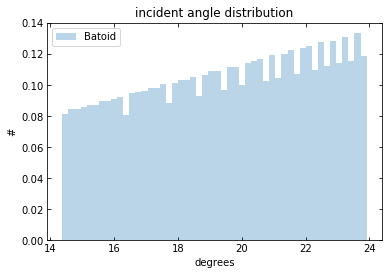

In [169]:
import batoid
telescope = batoid.Optic.fromYaml("LSST_r.yaml")
thx = np.deg2rad(1)
thy = np.deg2rad(0)
wavelength = 969.21e-9 # meters
rays = batoid.RayVector.asPolar(
    optic=telescope,
    wavelength=wavelength,
    theta_x=thx, theta_y=thy,
    nrad=1000, naz=300  #  These control how many parallel rays are created
)
# Make "full trace" of a small random subset of rays for visualization down 
# below.  This isn't needed generally, it's just for the 3D vis below.
tf = telescope.traceFull(rays[np.random.choice(len(rays), 30)])

# Now trace through the system
telescope.trace(rays)
# Limit to unvignetted rays
rays = rays[~rays.vignetted]

dxdz_batoid = rays.vx/rays.vz
dydz_batoid = rays.vy/rays.vz
#plt.hist(np.arctan(np.sqrt(dxdz**2+dydz**2))*180/np.pi,label = 'Fringing')

# We can convert these to a 1d histogram of incident angles
inc_thx, inc_thy = batoid.utils.dirCosToField(rays.vx, rays.vy, -rays.vz)
a,b,c= plt.hist(np.rad2deg(np.hypot(inc_thx, inc_thy)),label = 'Batoid',alpha = 0.3,bins = 50,density = True)
plt.xlabel("degrees")
plt.ylabel("#")
plt.legend(loc = 'best')
plt.title("incident angle distribution");

weight = []
for i in range(len(b)-1):
    weight.append(a[i]*(b[i+1]-b[i]))
    
weight = np.array(weight)


angles = b[:-1]*pi/180

In [65]:
SUM = np.zeros(shape = Fitting[3000,:].shape)
for i in tqdm(range(len(wavelengths))):
    SUM += normal_interpolators[str(wavelengths[i])](Fitting[3000,:])*line_weight[i]

100%|██████████| 89/89 [00:00<00:00, 3386.58it/s]


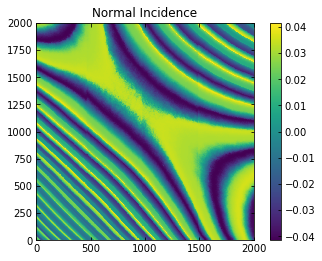

In [38]:
plt.title('Normal Incidence')
g = (np.max(SUM) + np.min(SUM))/2
plt.imshow(SUM/g-1,origin='lower')
plt.colorbar()

In [12]:


def Fringe_sim2 (inter_func,incident_angle,Weight,thickness):
    z_new = inter_func(thickness,incident_angle)
    z_new = z_new.reshape(len(z_new))
    count = np.sum(z_new*Weight)

    return(count)
    

In [64]:
def decision(probability):
    #compare = random.random(len(probability)) < probability
    #mask = compare == True
    #return(len(compare[mask]))
    return(np.sum(probability))

def Fringe_sim (inter_func,xz_slope,yz_slope,thickness):
    phi = np.arctan(np.sqrt(xz_slope**2+yz_slope**2))
    z_new = inter_func(thickness,phi)
    z_new = z_new.reshape(len(z_new))
        # Determine if will be absorbed or not
    count = decision(z_new)
    return(count)

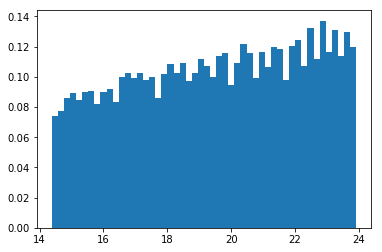

In [27]:
choice = np.random.choice(len(dxdz_batoid),30000)
plt.hist(np.arctan(np.sqrt(dxdz_batoid[choice]**2+dydz_batoid[choice]**2))*180/pi,bins = 50,density = True);
#plt.hist(np.rad2deg(np.hypot(inc_thx, inc_thy)),label = 'Batoid',alpha = 0.3,density = True)

In [216]:
results['937.9'] = fringing_res_center

In [214]:
results['944.2'] = fringing_res_center

In [208]:
results['946.1'] = fringing_res_center

In [219]:
results['950.5'] = fringing_res_center

In [218]:


fringing_res_center = np.zeros(shape=(20,2000))
for i in tqdm(range(fringing_res_center.shape[0])):
    for j in range(fringing_res_center.shape[1]):
            fringing_res_center[i,j] += Fringe_sim2(inter_func=interpolators['950.5'],incident_angle = angles, Weight= weight,thickness = Fitting[i,j])

100%|██████████| 20/20 [00:01<00:00, 14.59it/s]


In [53]:
def plot_amp (title,image):
    plt.title(title,fontsize = 12)
    g = (np.max(image)+np.min(image))/2
    plt.plot(image/g-1)
    #plt.colorbar()

In [138]:
line_weight = [0.1499623,0.10545333,0.12627837,0.09382043]
line_weight = line_weight/np.sum(line_weight)

Text(1, 0.5, 'Fringing amplitude')

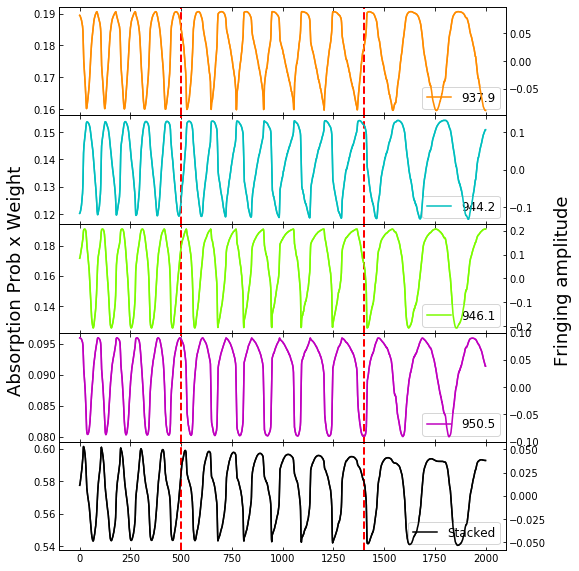

In [220]:
Sum = 0
i = 0
color = ['darkorange','c','lawngreen','m','r']
f,axes = plt.subplots(5,figsize = (8,10),sharex = True)
plt.subplots_adjust(hspace = 0)
for ax,data,w ,c in zip(axes,results,line_weight,color):
    DATA = results[str(data)][10,:]*w
    ax.plot(DATA,label = str(data),color = c)
    ax2 = ax.twinx()
    #g = np.mean(DATA)
    g= (np.max(DATA)+np.min(DATA))/2
    ax2.plot(DATA/g-1,color = c)
    ax.axvline(500,ls = '--',linewidth = 2,color = 'r')
    ax.axvline(1400,ls = '--',linewidth = 2,color = 'r')


    #ax2.plot()
    Sum += w*results[str(data)][10,:]
    ax.legend(fontsize = 12,loc = 'lower right')
axes[4].plot(Sum,label = 'Stacked',color = 'k')
axes[4].legend(fontsize = 12,loc = 'lower right')
axes[4].axvline(500,ls = '--',linewidth = 2,color = 'r')
axes[4].axvline(1400,ls = '--',linewidth = 2,color = 'r')


ax2 = axes[4].twinx()
#g = np.mean(Sum)
g = (np.max(Sum)+np.min(Sum))/2
ax2.plot(Sum/g-1,color = 'k')
f.text(0.05,0.5,'Absorption Prob x Weight',fontsize = 18,ha = 'center',va = 'center', rotation = 'vertical')
f.text(1,0.5,'Fringing amplitude',fontsize = 18,ha = 'center',va = 'center', rotation = 'vertical')

In [216]:
wavelengths2 = np.array([930.9,  931.0 ,  931.5,  931.6,  932.5,  932.6,  934.0 ,  937.7,
        937.9,  938.9,  940.5,  942.2,  944.2,  946.1,  947.9,  950.5,
        952.2,  955.5,  957.0 ,  961.0 ,  962.4,  967.1,  967.2,  968.3,
        968.5,  969.3,  970.2,  971.4])


wavelengths = np.array([1010.6, 1012.7, 1015.6, 1016.1, 1016.7, 1017.4, 1017.5, 1018.4,
       1019.2, 1020.6, 1021.2, 1021.4, 1022.9, 1023.3, 1028.8, 1028.9,
       1028.9, 1029. , 1029.9, 1031.2, 1035. , 1037.6, 1039.9, 1042.1,
       1045.3, 1047.2, 1051.2, 1052.8])

line_weight = np.array([0.02038837, 0.0566598 , 0.01640372, 0.01320525, 0.00660112,
       0.04007745, 0.03499094, 0.01580808, 0.06659889, 0.02646741,
       0.00964792, 0.07831055, 0.02108144, 0.02692684, 0.01777867,
       0.00833042, 0.16316168, 0.00829848, 0.05592381, 0.01741653,
       0.02842902, 0.08561777, 0.02917649, 0.07480472, 0.01762944,
       0.03910998, 0.0071078 , 0.0140474 ])

In [211]:
angles = np.linspace(th_min.to(u.rad).value, th_max.to(u.rad).value, 100)
weight = angles / np.sum(angles)

In [101]:
stacked_image_edge = np.zeros(shape=(1,4000))
for k in tqdm(range(len(wavelengths))):
    fringing_res3 = np.zeros(shape=(1,4000))
    for i in (range(fringing_res3.shape[0])):
        for j in range(fringing_res3.shape[1]):
                fringing_res3[i,j] += Fringe_sim2(inter_func=interpolator[str(wavelengths[k])],
                                                 incident_angle = angles, Weight= weight,thickness = Fitting[i+3000,j])
    stacked_image_edge += fringing_res3*line_weight[k]

100%|██████████| 19/19 [00:02<00:00,  7.96it/s]


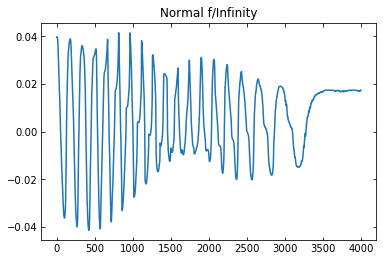

In [68]:
plt.title('Normal f/Infinity')
g = (np.max(SUM)+np.min(SUM))/2
plt.plot(SUM/g-1)

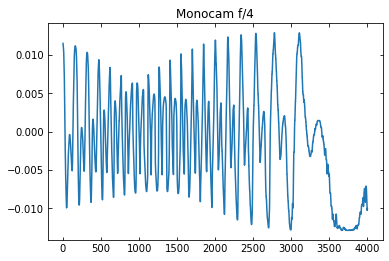

In [93]:
plt.title('Monocam f/4')
g = (np.max(stacked_image_mono[0])+np.min(stacked_image_mono[0]))/2
plt.plot(stacked_image_mono[0]/g-1)

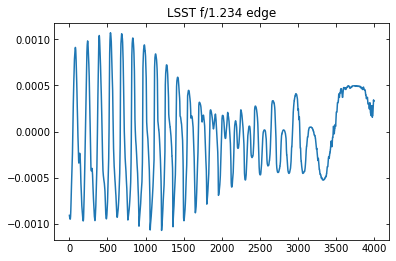

In [102]:
plt.title('LSST f/1.234 edge')
g = (np.max(stacked_image_edge[0])+np.min(stacked_image_edge[0]))/2
plt.plot(stacked_image_edge[0]/g-1)

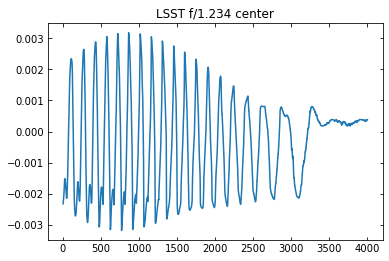

In [98]:
plt.title('LSST f/1.234 center')
g = (np.max(stacked_image_center[0])+np.min(stacked_image_center[0]))/2
plt.plot(stacked_image_center[0]/g-1)

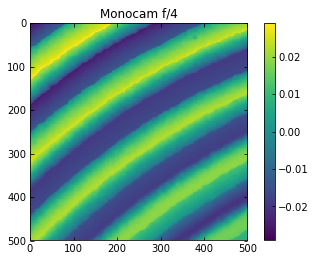

In [29]:
plt.title('Monocam f/4')
g = (np.max(stacked_image_mono)+np.min(stacked_image_mono))/2
plt.imshow(stacked_image_mono/g-1)
plt.colorbar()

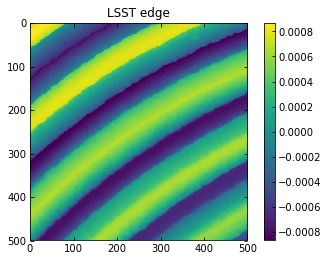

In [24]:
plt.title('LSST edge')
g = (np.max(stacked_image_edge)+np.min(stacked_image_edge))/2
plt.imshow(stacked_image_edge/g-1)
plt.colorbar()

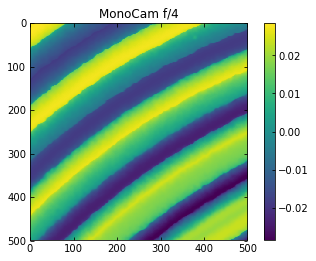

In [116]:
plt.title('MonoCam f/4')
g = (np.max(stacked_image_center)+np.min(stacked_image_center))/2
plt.imshow(stacked_image_center/g-1)
plt.colorbar()

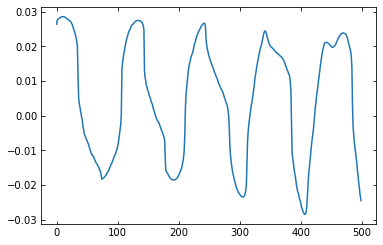

In [113]:
plt.plot(np.diag(stacked_image_center/g-1

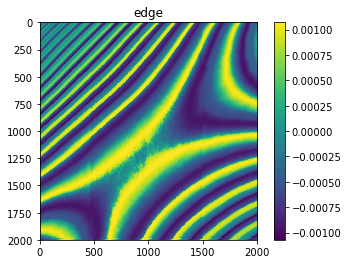

In [73]:
plot_amp('edge',stacked_image_edge)

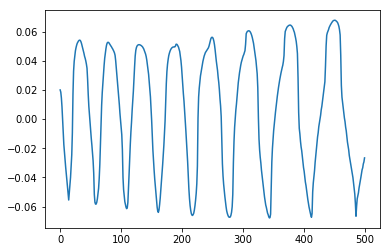

In [24]:
plt.plot(np.diag(stacked_image/g-1))

In [17]:
from tqdm import tqdm

In [72]:
dxdz_batoid = rays.vx/rays.vz
dydz_batoid = rays.vy/rays.vz

fringing_res = np.zeros(shape=(20,2000))


choice = np.random.choice(len(dxdz_batoid),30000)
for i in tqdm(range(fringing_res.shape[0])):
    for j in range(fringing_res.shape[1]):
            
            #choice = np.random.choice(len(dxdz_batoid),10000)
            fringing_res[i,j] += Fringe_sim(inter_func=interpolator['937.9'],xz_slope=dxdz_batoid[choice],yz_slope = dydz_batoid[choice], thickness = Fitting[i,j])

100%|██████████| 20/20 [02:08<00:00,  6.44s/it]


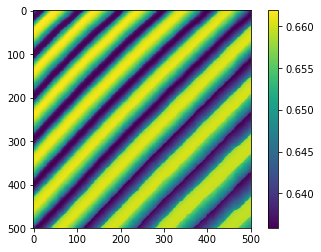

In [25]:
plt.imshow(fringing_res/30000)
plt.colorbar()

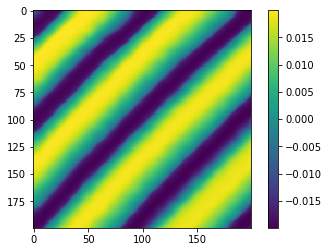

In [419]:
g = (np.max(fringing_res/30000)+np.min(fringing_res/30000))/2
plt.imshow(fringing_res/30000/g-1)
plt.colorbar()

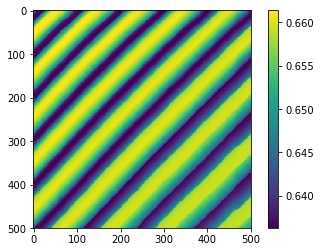

In [434]:
g = (np.max(fringing_res3)+np.min(fringing_res3))/2
plt.imshow(fringing_res3)
plt.colorbar()

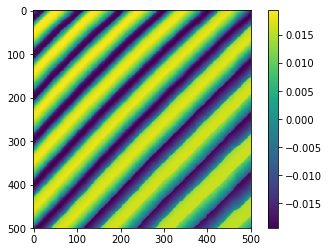

In [435]:
g = (np.max(fringing_res3)+np.min(fringing_res3))/2
plt.imshow(fringing_res3/g-1)
plt.colorbar()

In [22]:
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage

# Define some function for plotting, adjusting the z-scale.

def cmap_range(image_array, nsig=3):
    pixel_data = np.array(image_array, dtype=np.float).flatten()
    stats = afwMath.makeStatistics(pixel_data,
                                   afwMath.STDEVCLIP | afwMath.MEDIAN)
    median = stats.getValue(afwMath.MEDIAN)
    stdev = stats.getValue(afwMath.STDEVCLIP)
    vmin = max(min(pixel_data), median - nsig*stdev)
    vmax = min(max(pixel_data), median + nsig*stdev)
    return vmin, vmax

def im_show (data):
    #plt.figure(figsize = (8,8))
    vmin, vmax = cmap_range(data)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    plt.imshow(data,origin='lower',norm=norm,cmap = pylab.cm.hot)
    plt.colorbar()

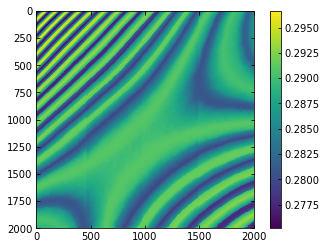

In [168]:
g = np.mean(fringing_res/1000)
plt.imshow(fringing_res/1000)
plt.colorbar()

In [171]:
line_sys = [979.21   , 979.3803 , 979.92255, 980.2357 , 981.09005,981.4675 ]

In [186]:
line_strength = np.array([12.03, 110.2 ,   3.55,  38.12,  1.34,  12.03])
weight = line_strength/np.sum(line_strength)

0.9999999999999998

In [195]:
coadd = np.zeros(shape = group['981.09005'].shape)
for i in range(len(line_sys)):
    coadd = coadd + weight[i]*group[str(line_sys[i])]/1000

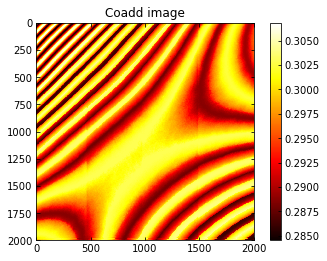

In [201]:
plt.title('Coadd image')
plt.imshow(coadd,cmap = pylab.cm.hot)
plt.colorbar()

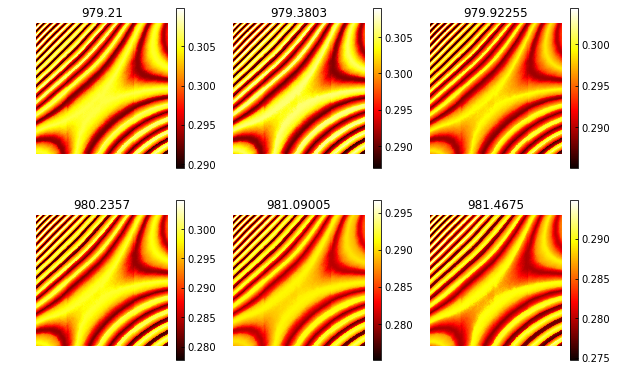

In [200]:
plt.figure(figsize = (10,10))
for i in range(len(line_sys)):
    plt.subplot(3,3,i+1)
    plt.title(line_sys[i])
    plt.imshow(group[str(line_sys[i])]/1000,cmap = pylab.cm.hot)
    plt.colorbar()
    plt.axis('off');

In [181]:
filename = 'data/980-line-sys-interp.pkl'
outfile = open(filename,'wb')
pickle.dump(group,outfile)
outfile.close()

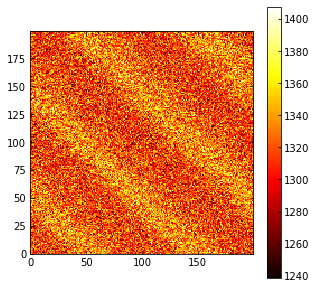

In [56]:
amp = False
plt.figure(figsize = (5,5))
if amp == True:
    g = np.mean(fringing_res)
    im_show(fringing_res/g-1)
    
else:
    im_show(fringing_res)

In [121]:
filename = 'data/980-line-sys-interp.pkl'
infile = open(filename,'rb')
new_dict = pickle.load(infile)
infile.close()


In [32]:
np.mean(fringing_res)

862.747252

In [37]:
862.747252/0.2859098052750016


3017.5504165384214

In [36]:
(np.max(new_dict['981.09005'][:500,:500]/1000)+np.min(new_dict['981.09005'][:500,:500]/1000))/2

0.2859098052750016

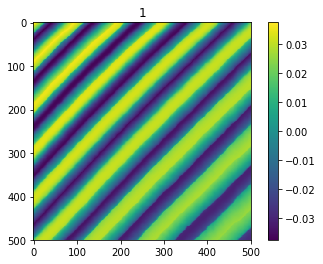

In [125]:
plot_amp('1',new_dict['981.09005'][:500,:500]/1000)

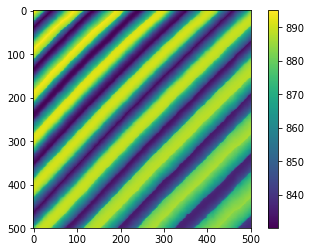

In [39]:
plt.imshow(new_dict['981.09005'][:500,:500]/1000*3017)
plt.colorbar()

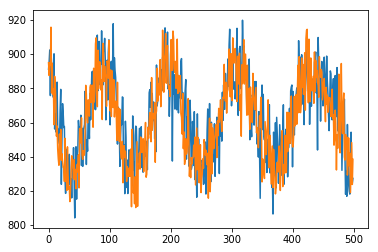

In [50]:
MIN = 200
MAX = 204
plt.plot(np.mean(s[MIN:MAX,],axis=0),label = 'smooth version')
plt.plot(np.mean(fringing_res[MIN:MAX,:],axis = 0),label = 'Interpolation method')

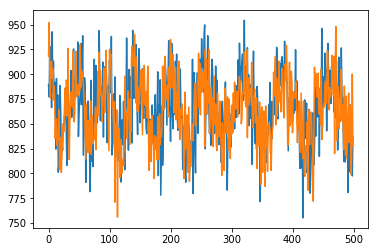

In [49]:
plt.plot(np.diag(s))
plt.plot(np.diag(fringing_res))

In [47]:
s = np.random.normal(new_dict['981.09005'][:500,:500]/1000*3017, np.sqrt(new_dict['981.09005'][:500,:500]/1000*3017))

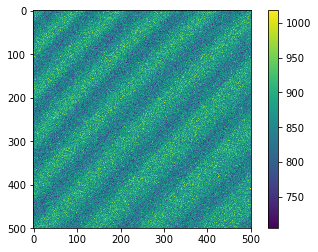

In [48]:
plt.imshow(s)
plt.colorbar()

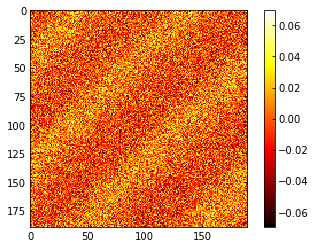

In [60]:
g = np.mean(new_dict[5:-5,5:-5])
plt.imshow(new_dict[5:-5,5:-5]/g-1,vmin = -0.07,vmax = 0.07,cmap = pylab.cm.hot)
plt.colorbar()

In [142]:
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

Text(0, 0.5, 'Fringing amplitude')

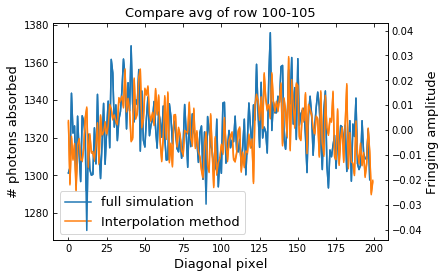

In [63]:
fig, ax1 = plt.subplots(figsize = (6,4))
MIN = 100
MAX = 105
plt.title('Compare avg of row %i-%i'%(MIN,MAX),fontsize = 13)
ax2 = ax1.twinx()

ax1.plot(np.mean(new_dict[MIN:MAX,1:-1],axis=0),label = 'full simulation')
ax1.plot(np.mean(fringing_res[MIN:MAX,:],axis = 0),label = 'Interpolation method')

g = np.mean(np.mean(new_dict[MIN:MAX,1:-1],axis=0))
ax2.plot(np.mean(new_dict[MIN:MAX,1:-1],axis=0)/g-1,label = 'full simulation')
g = np.mean(np.mean(fringing_res[MIN:MAX,:],axis = 0))
ax2.plot(np.mean(fringing_res[MIN:MAX,:],axis = 0)/g-1,label = 'Interpolation method')

ax1.legend(loc = 'lower left',fontsize= 13)
ax1.set_xlabel('Diagonal pixel',fontsize = 13)
ax1.set_ylabel('# photons absorbed',fontsize = 13)
ax2.set_ylabel('Fringing amplitude',fontsize= 13)